In [ ]:
datapoints = []
embeddings = []
# scatterplot

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def plot_embeddings(embeddings, datapoints):
    # create a dataframe
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['label'] = datapoints

    # create a scatter plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette='deep')

    # add labels
    for i in range(len(df)):
        plt.text(df['x'][i], df['y'][i], df['label'][i], fontsize=12)

    plt.show()

: 

In [27]:
### per language salary

text = """Mean Salary Score (ja): 1230410.1537
Mean Salary Score (en): 12353.9454
Mean Salary Score (ko): 27053749.9506
Mean Salary Score (ja): 2816602.6182
Mean Salary Score (en): 13233.6018
Mean Salary Score (ko): 18110878.0512
Mean Salary Score (ja): 1255077.8816
Mean Salary Score (en): 40719.6478
Mean Salary Score (ko): 10071172.7188
Mean Salary Score (ja): 9297364.1881
Mean Salary Score (en): 73741.6638
Mean Salary Score (ko): 878734288.2957
Mean Salary Score (ja): 2011005.4638
Mean Salary Score (en): 63712.2278
Mean Salary Score (ko): 35049997.5467
Mean Salary Score (ja): 5137310.0723
Mean Salary Score (en): 15446.2006
Mean Salary Score (ko): 39951207.1452
Mean Salary Score (ja): 1516956.1724
Mean Salary Score (en): 19369.0661
Mean Salary Score (ko): 26921023.1620
Mean Salary Score (ja): 2622233.3820
Mean Salary Score (en): 30765.8494
Mean Salary Score (ko): 12861301.2099
Mean Salary Score (ja): 1632236.0248
Mean Salary Score (en): 11162.6974
Mean Salary Score (ko): 8221173.1816
Mean Salary Score (ja): 2660184.8307
Mean Salary Score (en): 36490.1435
Mean Salary Score (ko): 41477788.4823
Mean Salary Score (ja): 4284992.8680
Mean Salary Score (en): 45410.1931
Mean Salary Score (ko): 29363754.8780
Mean Salary Score (ja): 1104875.4658
Mean Salary Score (en): 10467.6624
Mean Salary Score (ko): 7006070.7635"""


exchange_rate = {'ko': 0.00089, 'en': 1.0, 'ja': 0.0091}
salary = {'ko' : [], 'en' : [], 'ja' : []}
for line in text.split("\n"):
    lang = line.split(" ")[3].replace(":", "").replace("(", "").replace(")", "")
    score = float(line.split(": ")[1])
    salary[lang].append(score)
    
salary = {k: sum(v) / len(v) * exchange_rate[k] for k, v in salary.items()}

def calculate_average_scores(data, score_name='bert_score'):
# 각 언어별 bert score를 저장할 딕셔너리
    requirements_scores = {'ko': [], 'ja': [], 'en': [], 'es': []}
    description_scores = {'ko': [], 'ja': [], 'en': [], 'es': []}
    # 데이터에서 bert score 추출
    for model in data.values():
        for lang in ['ko', 'ja', 'en', 'es']:
            if lang in model:
                if 'requirement' in model[lang]:
                    requirements_scores[lang].append(model[lang]['requirement'][score_name])
                if 'description' in model[lang]:
                    description_scores[lang].append(model[lang]['description'][score_name])

    avg_requirements = {lang: np.mean(scores) if scores else 0
            for lang, scores in requirements_scores.items()}
    avg_descriptions = {lang: np.mean(scores) if scores else 0
            for lang, scores in description_scores.items()}
    return avg_requirements, avg_descriptions

In [8]:
import matplotlib.pyplot as plt
import numpy as np

markers = ['o', 's', 'D', '^', 'v', 'x', '+', '1', '2', '3', '4', '8', 'p', 'P', '*', 'h', 'H', 'X', 'd', '|', '_']
colors = plt.get_cmap('rainbow')(np.linspace(0, 1, 20))
facecolors = ['whitesmoke', 'lightgray', 'silver', 'darkgray', 'dimgray', 'black']

def parse_baseline_data(file_path='../../results/scores/baseline_truthfulness.txt'):

    with open(file_path, 'r') as f: 
        text = f.read()
    data = {}
    current_model = None
    
    lines = text.split('\n')
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        if line.startswith('=== Processing') and line.endswith('.jsonl ==='):
            current_model = line.split('=== Processing ')[1].replace('.jsonl ===', '')
            data[current_model] = {
                'requirement': {},
                'description': {}
            }
            i += 1
            continue
            
        if line.startswith('Random Baseline for'):
            category = line.split('Random Baseline for ')[1].strip(':')
            i += 1
            while i < len(lines) and ': ' in lines[i]:
                metric, value = lines[i].strip().split(': ')
                mean, std = value.split(' ± ')
                data[current_model][category][metric] = {
                    'mean': float(mean),
                    'std': float(std)
                }
                i += 1
            continue
        
        i += 1
        
    return data

def calculate_metric_means(data):
    # 모든 메트릭 수집
    metrics = set()
    for model in data.values():
        for category in model.values():
            metrics.update(category.keys())
    
    # 각 메트릭별 평균 계산
    metric_means = {
        'requirement': {metric: [] for metric in metrics},
        'description': {metric: [] for metric in metrics}
    }
    
    for model in data.values():
        for category in ['requirement', 'description']:
            for metric in metrics:
                if metric in model[category]:
                    metric_means[category][metric].append(model[category][metric]['mean'])
    
    # 최종 평균 계산
    final_means = {
        'requirement': {metric: np.mean(values) for metric, values in metric_means['requirement'].items()},
        'description': {metric: np.mean(values) for metric, values in metric_means['description'].items()}
    }
    
    return final_means

data = parse_baseline_data()
truthfulness_baseline = calculate_metric_means(data)



def parse_diversity(file_path='../../results/scores/diversity.txt'):
    with open(file_path, 'r') as f:
         text = f.read()
    metrics = {}
    current_model = None
    
    lines = text.split('\n')
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        if line.startswith('Processing') and line.endswith('.jsonl'):
            current_model = line.split('Processing ')[1].replace('.jsonl', '')
            metrics[current_model] = {}
            continue
            
        if line.startswith('entropy:'):
            metrics[current_model]['entropy'] = float(line.split(': ')[1])
        elif line.startswith('mean_distance:'):
            metrics[current_model]['mean_distance'] = float(line.split(': ')[1])
        elif line.startswith('variance:'):
            metrics[current_model]['variance'] = float(line.split(': ')[1])
    
    return metrics

def parse_truthfulness(file_path='../../results/scores/truthfulness.txt'):
    with open(file_path, 'r') as f:
         text = f.read()
    data = {}
    current_model = None
    
    lines = text.split('\n')
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        if line.startswith('Processing') and line.endswith('.jsonl'):
            current_model = line.split('Processing ')[1].replace('.jsonl', '')
            data[current_model] = {
                'requirement': {},
                'description': {},
                'salary': {'ja': 0, 'en': 0, 'ko': 0}
            }
            i += 1
            continue
        
        if line.startswith('Mean scores for'):
            category = line.split('Mean scores for ')[1].strip(':')
            i += 1
            while i < len(lines) and ':' in lines[i]:
                metric, value = lines[i].strip().split(': ')
                data[current_model][category][metric] = float(value)
                i += 1
            continue
            
        if line.startswith('Mean Salary Score'):
            currency = line[line.find('(')+1:line.find(')')]
            value = float(line.split(': ')[1])
            data[current_model]['salary'][currency] = value
            
        i += 1
        
    return data

def parse_soundedness(file_path='../../results/scores/soundedness.txt'):
    with open(file_path, 'r') as f:
        text = f.read()
    soundedness = {}
    current_model = None
    
    lines = text.split('\n')
    
    for i in range(1, len(lines), 4):  # 3줄씩 처리 (모델명, 숫자, 메트릭 딕셔너리)
        line = lines[i].strip()
        if not line:
            continue
            
        if line.startswith('Processing') and line.endswith('.jsonl'):
            current_model = line.split('Processing ')[1].replace('.jsonl', '')
            
            # 메트릭 딕셔너리 문자열을 실제 딕셔너리로 변환
            metrics_str = lines[i+2].strip()
            metrics_dict = eval(metrics_str)  # 안전한 환경에서만 사용
            
            soundedness[current_model] = metrics_dict
    
    return soundedness

def soundedness_baseline(file_path='../../results/scores/soundedness_baseline.txt'):
    with open(file_path, 'r') as f:
        text = f.read()
    total_metrics = {
        'bleu': [],
        'rouge_1': [],
        'rouge_2': [],
        'rouge_l': [],
        'meteor': [],
        'bert_score': [],
        'diversity': []
    }
    
    lines = text.split('\n')
    for line in lines:
        line = line.strip()
        
        # 메트릭 라인 찾기
        if any(metric in line for metric in total_metrics.keys()):
            try:
                metric, values = line.split(': ')
                mean = float(values.split(' ± ')[0])
                total_metrics[metric].append(mean)
            except:
                continue
    
    # 각 메트릭의 평균 계산
    baseline_means = {
        metric: np.mean(values) if values else 0 
        for metric, values in total_metrics.items()
    }
    
    return baseline_means

def convert_salary_to_usd(data):
    # 환율 설정 (JPY/USD, KRW/USD)
    exchange_rates = {'ja': 1/145, 'ko': 1/1300, 'en': 1}
    
    for model in data.values():
        salaries_usd = [model['salary'][curr] * exchange_rates[curr] 
                        for curr in ['ja', 'en', 'ko']]
        model['salary_usd'] = np.mean(salaries_usd)
    
    return data


In [10]:
truthfulness = parse_truthfulness()
truthfulness

{'gpt-4o-mini': {'requirement': {'bleu': 0.0112,
   'rouge_1': 0.0451,
   'rouge_2': 0.0079,
   'rouge_l': 0.0407,
   'meteor': 0.0384,
   'bert_score': 0.8906},
  'description': {'bleu': 0.0242,
   'rouge_1': 0.198,
   'rouge_2': 0.0466,
   'rouge_l': 0.1173,
   'meteor': 0.124,
   'bert_score': 0.8701},
  'salary': {'ja': 1266894.4099, 'en': 11367.5373, 'ko': 8076852.8166}},
 'google_gemma-2-2b-it': {'requirement': {'bleu': 0.004,
   'rouge_1': 0.0619,
   'rouge_2': 0.018,
   'rouge_l': 0.0575,
   'meteor': 0.0206,
   'bert_score': 0.8682},
  'description': {'bleu': 0.0136,
   'rouge_1': 0.1797,
   'rouge_2': 0.0377,
   'rouge_l': 0.1031,
   'meteor': 0.1151,
   'bert_score': 0.8485},
  'salary': {'ja': 1230410.1537, 'en': 12353.9454, 'ko': 27053749.9506}},
 'google_gemma-2-9b-it': {'requirement': {'bleu': 0.0054,
   'rouge_1': 0.0397,
   'rouge_2': 0.0092,
   'rouge_l': 0.0367,
   'meteor': 0.0264,
   'bert_score': 0.8763},
  'description': {'bleu': 0.0176,
   'rouge_1': 0.1903,
   

{'CohereForAI': array([0.39803922, 0.15947579, 0.99679532, 1.        ]), 'Qwen': array([0.0254902 , 0.73484497, 0.9160336 , 1.        ]), 'gpt-4o-mini': array([0.44901961, 0.99679532, 0.73484497, 1.        ])}
['Qwen_Qwen2.5-0.5B-Instruct', 'Qwen_Qwen2.5-1.5B-Instruct', 'Qwen_Qwen2.5-3B-Instruct', 'Qwen_Qwen2.5-7B-Instruct', 'Qwen_Qwen2.5-14B-Instruct', 'Qwen_Qwen2.5-32B-Instruct', 'Qwen_Qwen2.5-72B-Instruct', 'CohereForAI_aya-expanse-8b', 'CohereForAI_aya-expanse-32b', 'gpt-4o-mini']
[0.78  0.785 0.79  0.795 0.8   0.805 0.81  0.815 0.82 ]
[0.82 0.84 0.86 0.88 0.9 ]
[0.76 0.78 0.8  0.82 0.84 0.86 0.88]


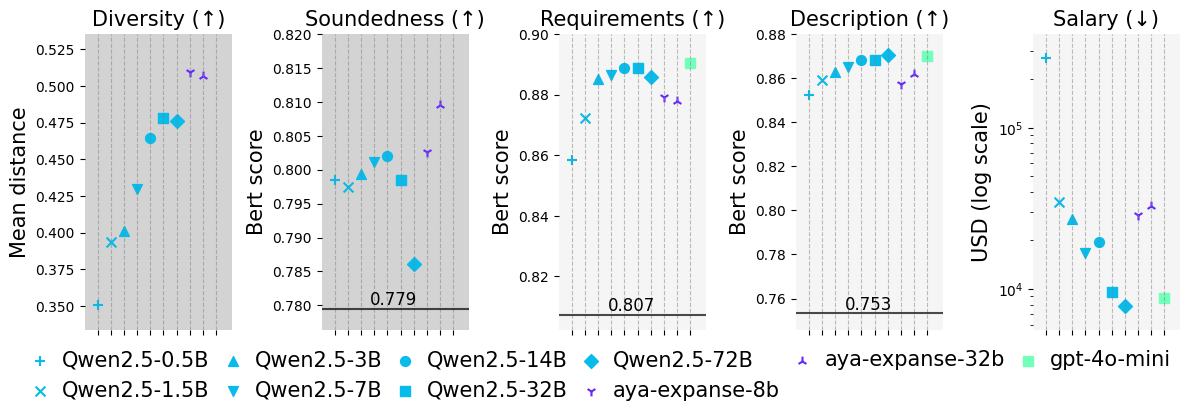

In [30]:
markers = [ '+', 'x', '^', 'v', 'o', 's', 'D', '1', '2', 's','3', '4', '8', 'p', 'P', '*', 'h', 'H', 'X', 'd', '|', '_']


def plot_performance(scoring_method='bert_score', diversity_method='entropy', fontsize=15, s_size=50, colormap = plt.get_cmap('rainbow')(np.linspace(0, 1, 20))):
    truthfulness = parse_truthfulness()
    diversity = parse_diversity()
    soundedness = parse_soundedness()
    baseline_2 = soundedness_baseline()
    data = convert_salary_to_usd(truthfulness)
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 3.5))
    models = ['Qwen_Qwen2.5-0.5B-Instruct', 'Qwen_Qwen2.5-1.5B-Instruct', 
              'Qwen_Qwen2.5-3B-Instruct', 'Qwen_Qwen2.5-7B-Instruct',  'Qwen_Qwen2.5-14B-Instruct', 'Qwen_Qwen2.5-32B-Instruct',
              'Qwen_Qwen2.5-72B-Instruct',
            #   'google_gemma-2-2b-it', 'google_gemma-2-9b-it', 'google_gemma-2-27b-it',
              'CohereForAI_aya-expanse-8b', 'CohereForAI_aya-expanse-32b', 'gpt-4o-mini',
              ]
    colors = {model: color for model, color in zip(
        list(set([r.split("_")[0] for r in models])), [colormap[i] for i in [1, 5, 9]])}
    print(colors)
    
    print(models)
    x = np.arange(len(models))
    
    plot_configs = [
        {
            'ax': axes[0],
            'scores': [diversity[model][diversity_method] for model in models if model in diversity],
            'title': 'Diversity (↑)',
            'ylabel': f'{diversity_method.replace("_", " ").capitalize()}',
            'baseline': 2.4086704796115304,
            'show_baseline': False,
            'log_scale': False,
            'facecolor': facecolors[1],
            'annotate_format': lambda x: f'{x:.2f}',  # 소수점 2자리
            'min_annotate_offset': 0.05,
            'max_annotate_offset': 0.05,
            'baseline_color': colormap[18]
        },
        {
            'ax': axes[1],
            'scores': [soundedness[model][scoring_method] for model in models if model in soundedness],
            'title': 'Soundedness (↑)',
            'ylabel': f'{scoring_method.replace("_", " ").capitalize()}',
            'baseline': baseline_2[scoring_method],
            'show_baseline': True,
            'log_scale': False,
            'facecolor': facecolors[1],
            'annotate_format': lambda x: f'{x*100:.1f}',
            'min_annotate_offset': 0.004,
            'max_annotate_offset': 0.01,
            'baseline_color': facecolors[-1]
        },
        {
            'ax': axes[2],
            'scores': [data[model]['requirement'][scoring_method] for model in models if model in data],
            'title': 'Requirements (↑)',
            'ylabel': f'{scoring_method.replace("_", " ").capitalize()}',
            'baseline': truthfulness_baseline['requirement'][scoring_method],
            'show_baseline': True,
            'log_scale': False,
            'facecolor': facecolors[0],
            'annotate_format': lambda x: f'{x*100:.1f}',  # 퍼센트로 표시
            'min_annotate_offset': 0.006,  # y축 범위의 5%만큼 위에 표시
            'max_annotate_offset': 0.005,  # y축 범위의 5%만큼 위에 표시
            'baseline_color': facecolors[-1]
        },
        {
            'ax': axes[3],
            'scores': [data[model]['description'][scoring_method] for model in models if model in data],
            'title': 'Description (↑)',
            'ylabel': f'{scoring_method.replace("_", " ").capitalize()}',
            'baseline': truthfulness_baseline['description'][scoring_method],
            'show_baseline': True,
            'log_scale': False,
            'facecolor': facecolors[0],
            'annotate_format': lambda x: f'{x*100:.1f}',
            'min_annotate_offset': 0.01,
            'max_annotate_offset': 0.01,
            'baseline_color': facecolors[-1]
        },
        {
            'ax': axes[4],
            'scores': [data[model]['salary_usd'] for model in models if model in data],
            'title': 'Salary (↓)',
            'ylabel': 'USD (log scale)',
            'baseline': None,
            'show_baseline': False,
            'log_scale': True,
            'facecolor': facecolors[0],
            'annotate_format': lambda x: f'{x/1000:.0f}k',  # k 단위로 표시
            'min_annotate_offset': 0.4,  # log scale이므로 더 큰 offset
            'max_annotate_offset': 0.4,  # log scale이므로 더 큰 offset
            'baseline_color': facecolors[-1]
        }
    ]
    legend_elements = []
    legend_labels = []
    
    # 각 서브플롯 설정
    for config_id, config in enumerate(plot_configs):
        ax = config['ax']
        scores = config['scores']
        
        ax.grid(axis='x', linestyle='--', alpha=0.5, color='gray')
        ax.set_xticks(list(range(len(models))))
        ax.set_xticklabels([], rotation=45, fontsize=fontsize-10, ha='right')
        # ax.set_yticklabels([f"{r*100:.0f}" for r in ax.get_yticks()], fontsize=fontsize-3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # y축 범위 계산
        ymin = min(scores + [config['baseline']] if config['baseline'] else scores) / (1 + config['min_annotate_offset'])
        ymax = max(scores) * (1 + config['max_annotate_offset'])
        
        # scatter plot과 annotation
        for i, (model, score) in enumerate(zip(models, scores)):
            model_group = model.split('_')[0]
            try:
                scatter = ax.scatter(x[i], score, marker=markers[i], 
                                   color=colors[model_group], s=s_size)
                # 첫 번째 subplot에서만 legend 요소 추가
                if config_id == 4:
                    legend_elements.append(scatter)
                    legend_labels.append(model.split("_")[-1].replace("-Instruct", '').replace('-it', ''))
            except:
                continue
            
        # y축 범위 설정
        ax.set_ylim(ymin, ymax)
        if config['show_baseline']:
            new_yticks = ax.get_yticks()[1:]
            print(new_yticks)
            ax.set_yticks(new_yticks)
            
        ax.set_xlim(-1, len(models)+0.2)
        ax.set_title(config['title'], fontsize=fontsize)
        ax.set_ylabel(config['ylabel'], fontsize=fontsize)
        ax.set_facecolor(config['facecolor'])
        
        # baseline 표시
        if config['show_baseline']:
            baseline = config['baseline']
            ax.axhline(y=baseline, color=config['baseline_color'], 
                        linestyle='-', alpha=0.7, linewidth=1.5)
            ax.text((len(models)-1)/2, baseline, f"{config['baseline']:0.3f}", 
                    color=config['baseline_color'], fontsize=fontsize-3, 
                    ha='center', va='bottom')
        
            
        # log scale 설정
        if config['log_scale']:
            ax.set_yscale('log')
        
    
    # 범례 설정
    plt.figlegend(legend_elements, legend_labels,
                  loc='upper center', ncol=6, fontsize=fontsize,
                  frameon=False, bbox_to_anchor=(0.5, 0.05),
                  borderaxespad=0.7, columnspacing=0.1,
                  handletextpad=0.05)
    
    plt.tight_layout()
    plt.savefig(f'../../results/plots/main_result_{scoring_method}_{diversity_method}.pdf', bbox_inches='tight')
   

plot_performance(scoring_method='bert_score', diversity_method='mean_distance')
